# Deep Learning-Based Plant Identification for Weed Control

This project uses deep learning such as Convolutional Neural Network (CNN) to classify plant images into four categories: soybean (crop), broadleaf weeds, grass weeds, and soil (background). The goal is to help automate weed detection in soybean fields by distinguishing crop plants from weeds and bare soil patches.



In [1]:
 # Installs run inside the exact interpreter that launched this notebook:
import sys
!{sys.executable} -m pip install kagglehub tifffile

In [2]:
#!C:/Users/bobbymarriott/anaconda3/bin/python -m pip install kagglehub

In [3]:
import kagglehub
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.trainers.data_adapters.py_dataset_adapter')

# Download dataset locally
path = kagglehub.dataset_download("fpeccia/weed-detection-in-soybean-crops")
print("Path:", path)

/Users/bobbymarriott/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path: /Users/bobbymarriott/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1


Reading from: /Users/bobbymarriott/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1/dataset/dataset/broadleaf/1.tif
Shape: (187, 201, 3)


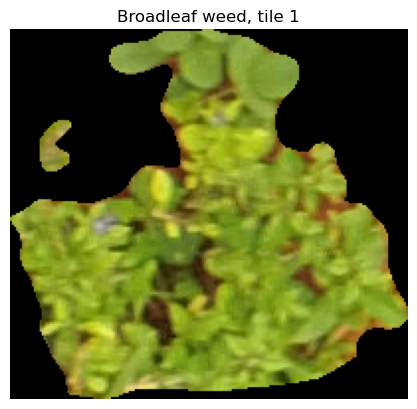

In [4]:
from pathlib import Path
import tifffile as tiff
import matplotlib.pyplot as plt

# 1) Make sure `path` is what kagglehub gave you:
#    e.g. Path('/Users/bobby…/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1')
base = Path(path)

# 2) Build the relative path from there:
img_path = base / "dataset" / "dataset" / "broadleaf" / "1.tif"

print("Reading from:", img_path)
img = tiff.imread(img_path)
print("Shape:", img.shape)

# 3) Plot
plt.imshow(img)
plt.axis("off")
plt.title("Broadleaf weed, tile 1")
plt.show()

In [5]:
# Check class distribution
# This shows how many images you have in each class folder.

import os

# Define base folder where the class subfolders are
base_folder = os.path.join(path, "dataset", "dataset")
classes = os.listdir(base_folder)

# Loop over each class folder and count files
for cls in classes:
    cls_path = os.path.join(base_folder, cls)
    count = len(os.listdir(cls_path))
    print(f"{cls}: {count} images")


soybean: 7376 images
grass: 3520 images
soil: 3249 images
broadleaf: 1191 images


In [6]:
# Import .TIF reader
import tifffile as tiff

# List to collect all image shapes found
shapes = []

# Loop through each class folder (e.g., broadleaf, soil, grass, soybean)
for cls in classes:
    cls_path = os.path.join(base_folder, cls)
    files = os.listdir(cls_path)[:10]  # Sample 10 per class
    for f in files:
        img_path = os.path.join(cls_path, f)
        img = tiff.imread(img_path)  # Read .TIF image
        shapes.append(img.shape)   # Save its shape

# When done collecting, display unique shapes in the sample
print("Sample shapes:", set(shapes))


Sample shapes: {(264, 278, 3), (253, 205, 3), (239, 230, 3), (246, 219, 3), (193, 200, 3), (279, 310, 3), (230, 241, 3), (270, 206, 3), (235, 232, 3), (201, 209, 3), (217, 224, 3), (221, 227, 3), (238, 246, 3), (256, 228, 3), (291, 248, 3), (259, 233, 3), (259, 242, 3), (208, 234, 3), (247, 222, 3), (247, 266, 3), (267, 239, 3), (235, 291, 3), (305, 278, 3), (254, 236, 3), (251, 210, 3), (253, 279, 3), (236, 266, 3), (218, 239, 3), (240, 230, 3), (257, 260, 3), (256, 223, 3), (319, 247, 3), (265, 283, 3), (260, 258, 3), (238, 280, 3), (247, 252, 3), (192, 282, 3), (214, 219, 3), (262, 246, 3), (236, 257, 3)}


##### images are in color (3 channels) but different sizes; need to resize to a standard shape before feeding into a CNN

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create image generator instance, splitting 20% of data into val set
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Create training data generator, 80% of the data
train_generator = datagen.flow_from_directory(
    base_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator (20% for validation)
val_generator = datagen.flow_from_directory(
    base_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 12270 images belonging to 4 classes.
Found 3066 images belonging to 4 classes.


In [9]:
base_folder = os.path.join(path, "dataset", "dataset")


In [10]:
# Convolutional Neural Network (CNN) - deep learning model to process image data

# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN architecture
model = Sequential([
    Input(shape=(224, 224, 3)),  # ✅ First layer defines the input shape
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show the model summary
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get the integer labels from your training generator
labels = train_generator.classes

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dictionary for Keras
class_weights = dict(zip(np.unique(labels), class_weights))
print("Computed class weights:", class_weights)

Computed class weights: {0: 3.2187827911857294, 1: 1.0893110795454546, 2: 1.1798076923076923, 3: 0.5198271479410269}


In [12]:
# Train the model with class_weight
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights   
)

# Plot accuracy and loss curves
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


Epoch 1/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 193s 501ms/step - accuracy: 0.6042 - loss: 0.9781 - val_accuracy: 0.7971 - val_loss: 0.5515
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8212 - loss: 0.5261  

KeyboardInterrupt: 